In [13]:
from model import seq2seq
from dataset import create_dataset, load_embedding

import os
import tensorflow as tf
from config import config
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Bidirectional, Activation, Dot
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # specify returnage   

In [2]:
word2vec = load_embedding()

In [3]:
embedding_matrix = word2vec

In [6]:
encoder_inputs = Input(shape=(config.MAX_LEN_ENCODER,), name='encoder_inputs')

encoder_embedding = Embedding(
    input_dim=embedding_matrix.vectors.shape[0],    
    output_dim=embedding_matrix.vectors.shape[1],   
    weights=[embedding_matrix.vectors],    
    input_length=config.MAX_LEN_ENCODER,
    trainable=False,
    name='encoder_embedding'
)(encoder_inputs)  

encoder_lstm = LSTM(
    config.HIDDEN_STATES_ENCODER, 
    activation='elu', 
    recurrent_dropout=config.RECURRENT_DROPOUT, 
    return_state=True,
    return_sequences=True,
    name='encoder_lstm'
)

encoder_stack_h, encoder_last_h, encoder_last_c = encoder_lstm(encoder_embedding)     
encoder_states = [encoder_last_h, encoder_last_c]  

In [7]:
decoder_inputs = Input(shape=(config.MAX_LEN_DECODER,), name='decoder_inputs')

decoder_embedding = Embedding(
    input_dim=embedding_matrix.vectors.shape[0],    
    output_dim=embedding_matrix.vectors.shape[1],   
    weights=[embedding_matrix.vectors],    
    input_length=config.MAX_LEN_DECODER,
    trainable=False,
    name='decoder_embedding'
)(decoder_inputs)  

decoder_lstm = LSTM(
    config.HIDDEN_STATES_DECODER, 
    activation='elu', 
    recurrent_dropout=config.RECURRENT_DROPOUT, 
    return_sequences=True, 
    return_state=True, 
    name='decoder_lstm'
)

decoder_stack_h, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = TimeDistributed(Dense(embedding_matrix.vectors.shape[0], activation="softmax"), name='decoder_dense')
decoder_stack_h = decoder_dense(decoder_stack_h)

In [17]:

attention = Dot(name='dot_dech_ench', axes=(2, 2)) ([decoder_stack_h, encoder_stack_h])
attention = Activation('softmax')(attention)
print(attention)

TypeError: __init__() missing 1 required positional argument: 'axes'

In [8]:
model = Model([encoder_inputs, decoder_inputs], decoder_stack_h)

metric = SparseCategoricalAccuracy()
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=config.LEARNING_RATE, clipnorm=config.CLIPNORM)
model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 100, 300)     77976600    encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, 30, 300)      77976600    decoder_inputs[0][0]             
______________________________________________________________________________________________

In [10]:
for layer in model.layers:
    print(layer.name)

encoder_inputs
decoder_inputs
encoder_embedding
decoder_embedding
encoder_lstm
decoder_lstm
decoder_dense


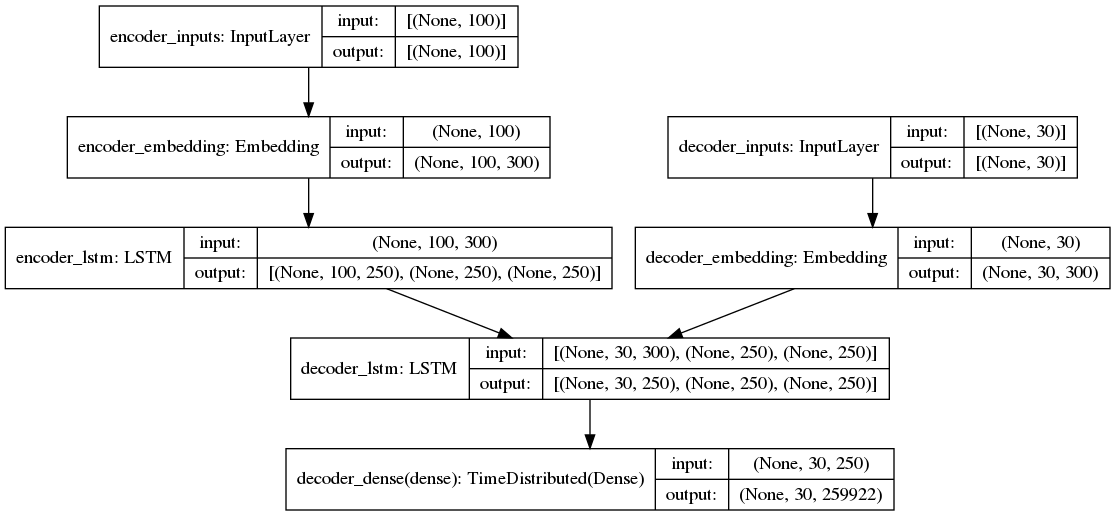

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)


## Rebuild

### Encoder

In [ ]:
encoder_inputs = model.input[0]
encoder_stack_h, state_h_enc, state_c_enc = model.get_layer('encoder_lstm').output          # encoder_lstm
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

encoder_model.summary()

In [ ]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True)


### Decoder

In [ ]:
decoder_input_layer = model.input[1] 
decoder_state_input_h = Input(shape=(config.HIDDEN_STATES_ENCODER,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(config.HIDDEN_STATES_ENCODER,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_layer = model.get_layer('decoder_embedding')
decoder_input_embedded = decoder_embedding_layer(decoder_input_layer)
decoder_lstm = model.get_layer('decoder_lstm')
decoder_stack_h, state_h_dec, state_c_dec = decoder_lstm(decoder_input_embedded, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.get_layer('decoder_dense')
decoder_stack_h = decoder_dense(decoder_stack_h)
decoder_model = Model([decoder_input_layer] + decoder_states_inputs, [decoder_stack_h] + decoder_states)

decoder_model.summary()

In [ ]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True)
